# NP activity collection

**Before running the script, please download the ChEMBL data (version 32) from official website and put it in the data subfolder.**
- https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/releases/chembl_32/chembl_32_sqlite.tar.gz


discription of ChemBL database:
- https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/latest/schema_documentation.html

## 1. Loading data

In [14]:
import pandas as pd
import sqlite3
inp = sqlite3.connect('../data/inp.db')
lotus = pd.read_sql('SELECT * FROM lotusNP', inp)
inp.close()
lotus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276518 entries, 0 to 276517
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   lotus_id                   276518 non-null  object
 1   smiles                     276518 non-null  object
 2   inchikey                   276518 non-null  object
 3   pathway                    276518 non-null  object
 4   superclass                 276518 non-null  object
 5   class                      276518 non-null  object
 6   connection_status_npclass  276518 non-null  int64 
 7   connection_status_pubchem  276518 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 16.9+ MB


In [15]:
chembl = sqlite3.connect('../data/chembl_32.db')

In [16]:
compounds = pd.read_sql('SELECT molregno, standard_inchi_key FROM compound_structures', chembl)
compounds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327928 entries, 0 to 2327927
Data columns (total 2 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   molregno            int64 
 1   standard_inchi_key  object
dtypes: int64(1), object(1)
memory usage: 35.5+ MB


In [17]:
sql = '''SELECT activities.activity_id, activities.assay_id, activities.molregno, activities.standard_relation, activities.standard_value,
		    activities.standard_units, activities.standard_flag, activities.standard_type, activities.pchembl_value,
            assays.tid,
            target_dictionary.target_type,
            protein_classification.pref_name, protein_classification.class_level
        FROM activities 
            LEFT JOIN assays ON activities.assay_id = assays.assay_id
            LEFT JOIN target_dictionary ON assays.tid = target_dictionary.tid
            LEFT JOIN target_components ON assays.tid = target_components.tid
            LEFT JOIN component_class ON target_components.component_id = component_class.component_id
            LEFT JOIN protein_classification ON component_class.protein_class_id = protein_classification.protein_class_id'''
activities = pd.read_sql(sql, chembl)
activities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21571544 entries, 0 to 21571543
Data columns (total 13 columns):
 #   Column             Dtype  
---  ------             -----  
 0   activity_id        int64  
 1   assay_id           int64  
 2   molregno           int64  
 3   standard_relation  object 
 4   standard_value     float64
 5   standard_units     object 
 6   standard_flag      int64  
 7   standard_type      object 
 8   pchembl_value      float64
 9   tid                int64  
 10  target_type        object 
 11  pref_name          object 
 12  class_level        float64
dtypes: float64(3), int64(5), object(5)
memory usage: 2.1+ GB


In [19]:
chembl.close()

## merge to NP_activities

In [20]:
np_molregno = compounds.loc[compounds['standard_inchi_key'].isin(lotus['inchikey'].values),'molregno']
np_molregno.shape

(36877,)

In [21]:
np_activities = activities[activities['molregno'].isin(np_molregno)]
np_activities = pd.merge(np_activities,compounds, how='left', on='molregno')
np_activities = pd.merge(np_activities,lotus[['lotus_id','inchikey']], 
                        how='left', left_on='standard_inchi_key',right_on='inchikey')
del np_activities['standard_inchi_key']
del np_activities['inchikey']
del np_activities['molregno']
np_activities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1026901 entries, 0 to 1026900
Data columns (total 13 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   activity_id        1026901 non-null  int64  
 1   assay_id           1026901 non-null  int64  
 2   standard_relation  694466 non-null   object 
 3   standard_value     817801 non-null   float64
 4   standard_units     784484 non-null   object 
 5   standard_flag      1026901 non-null  int64  
 6   standard_type      1026901 non-null  object 
 7   pchembl_value      148311 non-null   float64
 8   tid                1026901 non-null  int64  
 9   target_type        1026901 non-null  object 
 10  pref_name          248010 non-null   object 
 11  class_level        248010 non-null   float64
 12  lotus_id           1026901 non-null  object 
dtypes: float64(3), int64(4), object(6)
memory usage: 101.9+ MB


In [22]:
np_activities.sort_values(by='pchembl_value', inplace=True)
np_activities.drop_duplicates(subset=['lotus_id','tid'], keep='first',inplace=True)
np_activities.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354795 entries, 30347 to 1026899
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   activity_id        354795 non-null  int64  
 1   assay_id           354795 non-null  int64  
 2   standard_relation  188878 non-null  object 
 3   standard_value     292068 non-null  float64
 4   standard_units     290795 non-null  object 
 5   standard_flag      354795 non-null  int64  
 6   standard_type      354795 non-null  object 
 7   pchembl_value      68074 non-null   float64
 8   tid                354795 non-null  int64  
 9   target_type        354795 non-null  object 
 10  pref_name          98626 non-null   object 
 11  class_level        98626 non-null   float64
 12  lotus_id           354795 non-null  object 
dtypes: float64(3), int64(4), object(6)
memory usage: 37.9+ MB


In [23]:
conn = sqlite3.connect('../data/inp.db')
np_activities.to_sql('np_activities',conn, if_exists='replace',index=False)
conn.close()

## active px and NP class

In [1]:
import pandas as pd
import sqlite3
from lib.plot import heatmap_value_counts, joy, bar

In [2]:
conn = sqlite3.connect('../data/iNP.db')
np_activities = pd.read_sql('SELECT * FROM np_activities', conn)
lotus = pd.read_sql('SELECT * FROM lotusNP', conn)
conn.close()

In [3]:
np_activities = pd.merge(np_activities,lotus[['lotus_id','pathway']],how='left',on='lotus_id')
np_activities.replace(to_replace=r'^\s*$', value='Other', regex=True, inplace=True)

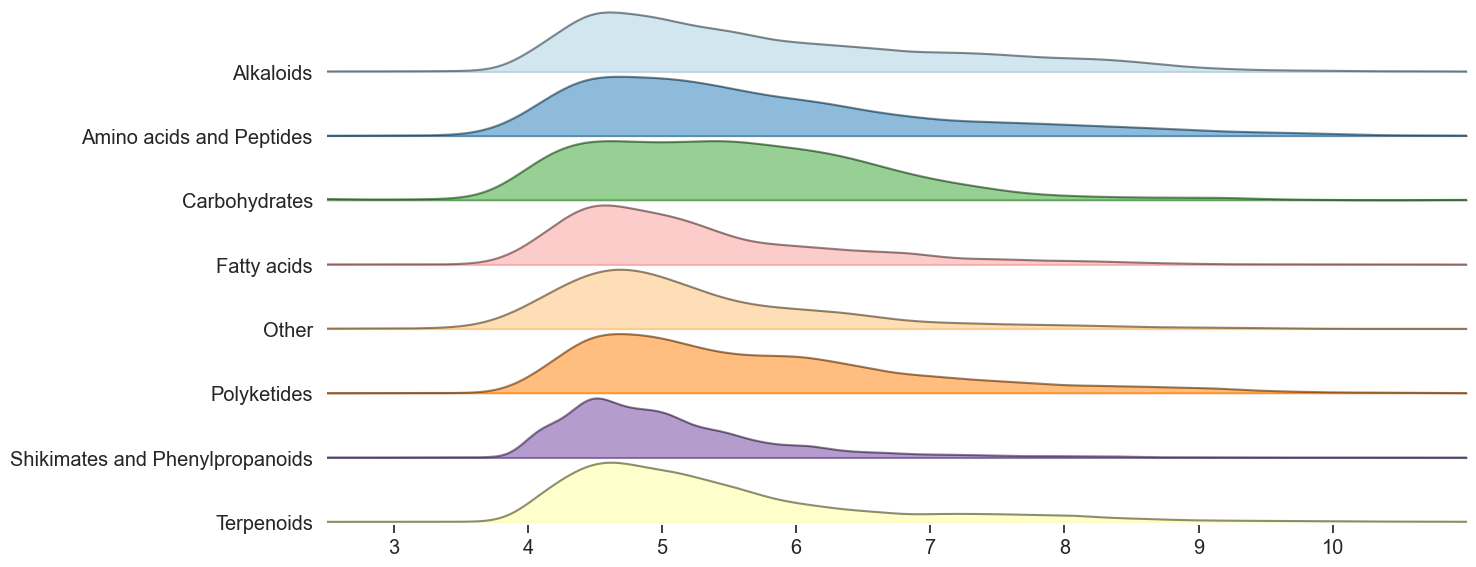

In [4]:
fig = joy(np_activities, x='pchembl_value',y='pathway', x_range =(2.5, np_activities['pchembl_value'].max()))
fig.savefig('../plot/3_np_activities_pathway_峰峦图.svg', transparent=True)